In [1]:
!pip install -q newsapi-python
!pip install -q -U google-generativeai

Number of articles: 21
Article 1: 90/100 - Fed rate cut boosts dollar rally 
https://www.thehindubusinessline.com/portfolio/technical-analysis/currency-outlook-fed-boosts-the-dollar-rally/article69012245.ece
Article 2: 90/100 - The dollar is expected to weaken less than expected next year, according to UBS. 
https://www.investing.com/news/forex-news/dollar-to-weaken-less-than-expected-next-year-ubs-3785190
Article 3: 50/100 - Article discusses automated forex trading but provides no specific information relevant to EURUSD. 
https://www.ibtimes.com/forex-trading-auto-pilot-avenix-fzcos-fxgenix-merges-human-logic-digital-precision-3755878
Article 4: 50/100 - Article discusses the launch of a new forex robot, FXSpire, by Avenix Fzco. 
https://www.ibtimes.com/avenix-fzco-takes-forex-trading-new-fxspire-robot-3755858
Article 5: 50/100, Article reports on the dollar's resumption of its uptrend due to rising US Treasury yields. 
https://www.thehindubusinessline.com/portfolio/technical-analysi

Article 17: 50/100 - Technical analysis of EUR/USD and USD/JPY 
https://www.cityindex.com/en-uk/news-and-analysis/us-dollar-price-action-setups-video-eurusd-usdjpy-12-3-24/


Waiting for api to cool down...
Article 18: 50/100 No analysis 
https://www.thehindubusinessline.com/portfolio/big-story/brace-for-a-strong-dollar-in-2025/article68926423.ece
Article 19: 50/100. Consumer inflation in Russia has accelerated. 
https://www.sostav.ru/blogs/269934/54145
Article 20: 95/100 - Dollar continues to rise 
https://www.thehindubusinessline.com/portfolio/technical-analysis/currency-outlook-dollar-on-a-strong-footing/article68901736.ece
Article 21: 50/100 - The article reports on the rise and fall of Russian stock market indexes, but contains no information relevant to EURUSD. 
https://www.sostav.ru/blogs/269934/53893


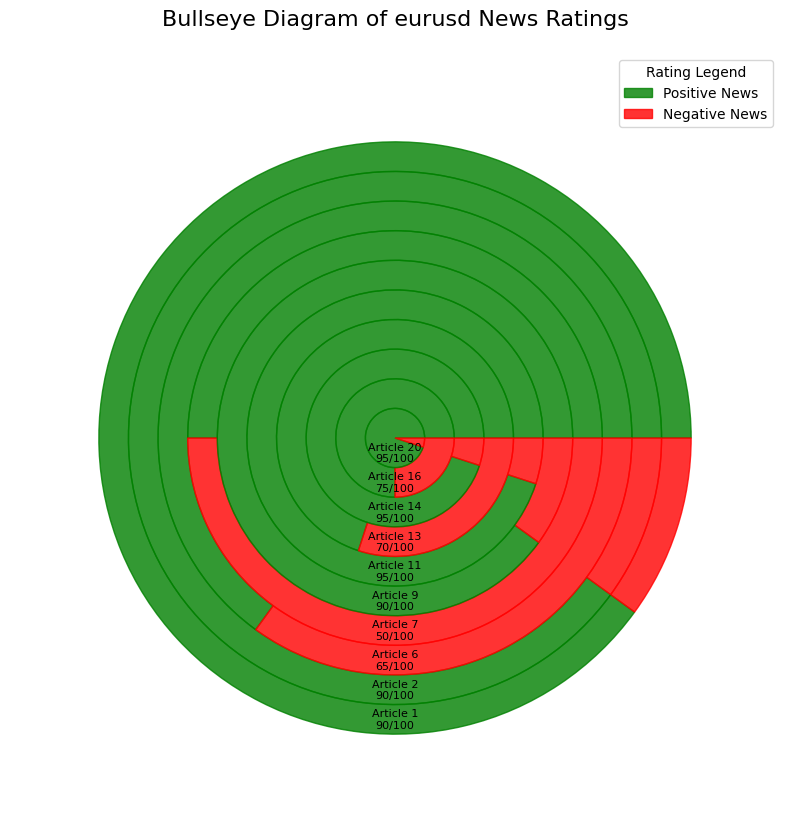

In [2]:
import google.generativeai as genai
import os
import time
from newsapi import NewsApiClient
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Wedge

class News_Analyser:
    def __init__(self,ticker_name='eurusd', num_articles=100):
        self.newsapi = NewsApiClient(api_key='')

        genai.configure(api_key="")
        self.model1 = genai.GenerativeModel('models/gemini-1.0-pro')

        genai.configure(api_key="")
        self.model2 = genai.GenerativeModel('models/gemini-1.0-pro')

        genai.configure(api_key="")
        self.model3 = genai.GenerativeModel('models/gemini-1.0-pro')

        # for m in genai.list_models():
        #      if 'generateContent' in m.supported_generation_methods:
        #         print(m.name)

        self.ticker_name = ticker_name
        articles = self.get_forex_news(ticker_name.upper(),page_size=num_articles)
        print(f"Number of articles: {len(articles)}")
        ratings = []
        for idx,article in enumerate(articles):
            LLM_Analysis = self.ask_LLM(f"""Im going to share with you a news article about {ticker_name}, ONLY respond with a rating of n/100 of how good the news are concerning the {ticker_name} (e.g if you gave 95/100 it means the stock will go up, anything below 50/100 is considered bearish and vis versa) OR if you there isnt any news then give it 50/100, here's the article: {article}. PLEASE ONLY RESPOND WITH A NUMBER AND 1 LINE SUMMARY OF THE ARTICLE CONTENT AND NOTHING ELSE!!!!!!""",model1=self.model1,model2=self.model2,model3=self.model3)
            print(f"Article {idx+1}: {LLM_Analysis} \n{article['url']}")
            try:
                if int(LLM_Analysis.split("/")[0]) != 50:
                    ratings.append((idx, int(LLM_Analysis.split("/")[0])))
            except:
                ratings.append((idx, 50))

        self.plot_bullseye_diagram(ratings)

    def ask_LLM(self, query,model1,model2,model3):
        try:
            response = model1.generate_content(query)
        except:
            try:
                response = model2.generate_content(query)
            except:
                try:
                    response = model3.generate_content(query)
                except:
                    print("Waiting for api to cool down...")
                    time.sleep(30)
                    return "50/100 No analysis"
        return response.text

    def get_forex_news(self, pair, page_size=100, num_pages=1):
        query = pair
        articles_details = []

        for page in range(1, num_pages + 1):
            news = self.newsapi.get_everything(
                q=query,
                language='en',
                sort_by='publishedAt',
                page_size=page_size,  # Number of articles per page
                page=page  # Page number for pagination
            )

            if not news['articles']:
                print(f"No articles found for page {page}.")
                os._exit(0)
                break

            for article in news['articles']:
                articles_details.append({
                    "title": article['title'],
                    "url": article['url'],
                    "date": article['publishedAt'],
                    "content": article.get('content', 'Content not available')
                })

        return articles_details


    def plot_bullseye_diagram(self, ratings):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')
        ax.axis('off')
        total_articles = len(ratings)
        max_radius = 5
        radius_step = max_radius / total_articles
        for i, (idx, rating) in enumerate(ratings):
            percentage = rating / 100

            outer_radius = max_radius - i * radius_step
            inner_radius = outer_radius - radius_step
            theta1 = 0
            theta2_green = 360 * percentage  # Angle for green
            theta2_red = 360  # Full circle for red
            green_wedge = Wedge((0, 0), outer_radius, theta1, theta2_green, width=radius_step, color='green', alpha=0.8)
            ax.add_patch(green_wedge)
            red_wedge = Wedge((0, 0), outer_radius, theta2_green, theta2_red, width=radius_step, color='red', alpha=0.8)
            ax.add_patch(red_wedge)
            label_radius = (outer_radius + inner_radius) / 2
            ax.text(0, -label_radius, f"Article {idx + 1}\n{rating}/100",color="black", fontsize=8, ha="center", va="center")

        ax.set_xlim(-max_radius * 1.3, max_radius * 1.3)
        ax.set_ylim(-max_radius * 1.3, max_radius * 1.3)
        legend_patches = [
            Wedge((0, 0), 1, 0, 180, color='green', alpha=0.8, label="Positive News"),
            Wedge((0, 0), 1, 180, 360, color='red', alpha=0.8, label="Negative News"),
        ]
        ax.legend(handles=legend_patches, loc="upper right", fontsize=10, title="Rating Legend")
        plt.title(f"Bullseye Diagram of {self.ticker_name} News Ratings", fontsize=16, pad=20)
        plt.show()

news_analysis_tool = News_Analyser(ticker_name='eurusd', num_articles=100)

